Spoken digit recognition using the Free Spoken Digit Dataset (FSDD)

At first, import packages to be used for the experiments

In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import time

from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from pyrcn.echo_state_network import ESNRegressor
import matplotlib
from matplotlib import pyplot as plt
#Options
params = {'image.cmap' : 'RdBu',
          'text.usetex' : True,
          'font.size' : 11,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 16,
          'ytick.labelsize' : 16,
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import librosa

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


Print number of files that are included in the dataset

In [2]:
all_files = glob.glob(r"E:\free-spoken-digit-dataset\recordings\*.wav")
print(len(all_files))

3000


Feature visualization

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


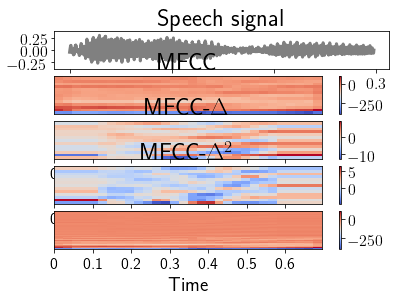

In [3]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
# X = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(5, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(5, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(5, 1, 3)
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(5, 1, 4)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.subplot(5, 1, 5)
librosa.display.specshow(np.vstack((mfcc, mfcc_delta, mfcc_delta2)), x_axis='time')
plt.colorbar()
plt.tight_layout()

Extract features and labels from all signals

In [4]:
X = [None] * len(all_files)
y = [None] * len(all_files)
print("extracting features...")
with tqdm(total=len(all_files)) as pbar:
    for k, f in enumerate(all_files):
        basename = os.path.basename(f).split('.')[0]
        # Get label (0-9) of recording.
        label = int(basename.split('_')[0])
        # Load the audio signal and normalize it.
        x, sr = librosa.core.load(f, sr=None, mono=False)
        # x /= np.max(np.abs(x))
        mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        X[k] = mfcc.T
        y[k] = label
        pbar.update(1)
print("done!")

extracting features...


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:15<00:00, 199.00it/s]


done!


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1, stratify=y_test)

Validate training and test sizes

In [6]:
print(len(X_train), len(y_train), X_train[0].shape, y_train[0])
print(len(X_val), len(y_val), X_val[0].shape, y_val[0])
print(len(X_test), len(y_test), X_test[0].shape, y_test[0])

2400 2400 (40, 13) 5
300 300 (54, 13) 9
300 300 (41, 13) 3


Normalize all features using the StandardScaler from scikit-learn.

In [7]:
scaler = StandardScaler().fit(X=np.vstack(X_train))
X_train_scaled = [scaler.transform(X) for X in X_train]
X_val_scaled = [scaler.transform(X) for X in X_val]
X_test_scaled = [scaler.transform(X) for X in X_test]

Feature visualization

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


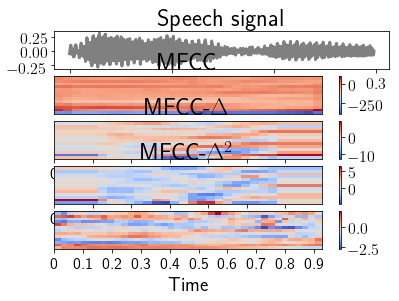

In [8]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(5, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(5, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(5, 1, 3)
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(5, 1, 4)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.subplot(5, 1, 5)
librosa.display.specshow(X_train_scaled[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()

One-Hot encoding of labels

In [9]:
enc = OneHotEncoder(sparse=False).fit(X=np.asarray(y_train).reshape(-1, 1))

Random experiments

In [10]:
for rs in range(20):
    base_esn = ESNRegressor(k_in=-1, input_scaling=0.4, spectral_radius=0.1, bias=0.0, leakage=0.1, reservoir_size=500,
                            k_res=10, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                            bi_directional=False, solver='ridge', beta=1e-3, random_state=rs)
    print("Train the ESN model...")
    esn = clone(base_esn)
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, update_output_weights=False)
    esn.finalize()
    print("... done!")
    Y_true_train = []
    Y_pred_train = []
    mse_train = []
    mse_test = []
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
    print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
    print("MSE training: %f\n" % (np.mean(mse_train)))
    
    Y_true_test = []
    Y_pred_test = []
    mse_test = []
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
    print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
    print("MSE test: %f\n" % (np.mean(mse_test)))


Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=0, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355       240
           1  0.9956521739 0.9541666667 0.9744680851       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  0.9913043478 0.9500000000 0.9702127660       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9876033058 0.9958333333 0.9917012448       240
           6  0.9914893617 0.9708333333 0.9810526316       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9876543210 1.0000000000 0.9937888199       240

    accuracy                      0.9858333333      2400
   macro avg  0.9862412952 0.9858333333 0.9858226684      2400


MSE test: 0.041275

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=4, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9411764706 1.0000000000 0.9696969697       240
           1  0.9957446809 0.9750000000 0.9852631579       240
           2  0.9917355372 1.0000000000 0.9958506224       240
           3  0.9955752212 0.9375000000 0.9656652361       240
           4  0.9958333333 0.9958333333 0.9958333333       240
           5  0.9917355372 1.0000000000 0.9958506224       240
           6  0.9831932773 0.9750000000 0.9790794979       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9835390947 0.9958333333 0.9896480331       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9870833333      2400
   macro avg  0.9874383775 0.9870833333 0


MSE test: 0.041013

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=8, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355       240
           1  0.9957264957 0.9708333333 0.9831223629       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9291666667 0.9632829374       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9917012448 0.9958333333 0.9937629938       240
           6  0.9794238683 0.9916666667 0.9855072464       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9917355372 1.0000000000 0.9958506224       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9879166667      2400
   macro avg  0.9883639013 0.9879166667 0


MSE test: 0.040920

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=12, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9338521401 1.0000000000 0.9657947686       240
           1  0.9955947137 0.9416666667 0.9678800857       240
           2  0.9917355372 1.0000000000 0.9958506224       240
           3  1.0000000000 0.9291666667 0.9632829374       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9716599190 1.0000000000 0.9856262834       240
           6  0.9872881356 0.9708333333 0.9789915966       240
           7  0.9916666667 0.9916666667 0.9916666667       240
           8  0.9756097561 1.0000000000 0.9876543210       240
           9  0.9917012448 0.9958333333 0.9937629938       240

    accuracy                      0.9829166667      2400
   macro avg  0.9834958736 0.9829166667 


MSE test: 0.041745

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(beta=0.001, input_scaling=0.4, k_in=-1, leakage=0.1,
             random_state=16, spectral_radius=0.1):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355       240
           1  1.0000000000 0.9833333333 0.9915966387       240
           2  1.0000000000 0.9916666667 0.9958158996       240
           3  0.9955555556 0.9333333333 0.9634408602       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9917355372 1.0000000000 0.9958506224       240
           6  0.9832635983 0.9791666667 0.9812108559       240
           7  1.0000000000 0.9958333333 0.9979123173       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9879166667      2400
   macro avg  0.9883413510 0.9879166667 


MSE test: 0.041448



Initialize an Echo State Network

In [64]:
base_esn = ESNRegressor(k_in=-1, input_scaling=0.3, spectral_radius=0.0, bias=0.0, leakage=1.0, reservoir_size=500,
                        k_res=10, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                        bi_directional=False, solver='ridge', beta=1e-3, random_state=1)

y_tmp = enc.transform(np.asarray(y_train[0]).reshape(1, -1))
y_tmp = np.repeat(np.atleast_2d(y_tmp), repeats=X_train_scaled[0].shape[0], axis=0)
base_esn.partial_fit(X=X_train_scaled[0], y=y_tmp, update_output_weights=False)
del(y_tmp)
w_in = np.pad(base_esn.input_weights_, ((0, 500), (0, 0)), mode='constant', constant_values=0)

base_esn = ESNRegressor(k_in=-1, input_scaling=0.8, spectral_radius=0.3, bias=0.6, leakage=0.1, reservoir_size=1000,
                        k_res=10, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                        bi_directional=False, solver='ridge', beta=1e-3, random_state=1)

Clone the base_esn and fit it on the training data

In [65]:
esn = clone(base_esn)
esn.initialize_from_outside(y=enc.transform(np.asarray(y_train[0]).reshape(-1, 1)), n_features=X_train[0].shape[0], input_weights=w_in)
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, update_output_weights=False)
        pbar.update(1)
esn.finalize()
print("... done!")

Train the ESN model...


100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:57<00:00, 42.08it/s]


... done!


Test the model on the training and test set

100%|█████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:19<00:00, 122.78it/s]


Classification training report for estimator ESNRegressor(beta=0.001, bias=0.6, input_scaling=0.8, k_in=-1, leakage=0.1,
             random_state=1, reservoir_size=1000, spectral_radius=0.3):
              precision    recall  f1-score   support

           0  0.9638554217 1.0000000000 0.9815950920       240
           1  1.0000000000 0.9916666667 0.9958158996       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  1.0000000000 0.9625000000 0.9808917197       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9915966387 0.9833333333 0.9874476987       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9836065574 1.0000000000 0.9917355372       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9925000000      2400
   macro avg  0.9926627488 0.9925000000 0.9924985803      2400
w

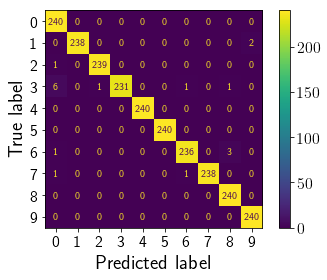

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 127.68it/s]


Classification test report for estimator ESNRegressor(beta=0.001, bias=0.6, input_scaling=0.8, k_in=-1, leakage=0.1,
             random_state=1, reservoir_size=1000, spectral_radius=0.3):
              precision    recall  f1-score   support

           0  0.9677419355 1.0000000000 0.9836065574        30
           1  1.0000000000 1.0000000000 1.0000000000        30
           2  1.0000000000 1.0000000000 1.0000000000        30
           3  1.0000000000 0.9333333333 0.9655172414        30
           4  1.0000000000 1.0000000000 1.0000000000        30
           5  1.0000000000 1.0000000000 1.0000000000        30
           6  1.0000000000 1.0000000000 1.0000000000        30
           7  1.0000000000 1.0000000000 1.0000000000        30
           8  0.9677419355 1.0000000000 0.9836065574        30
           9  1.0000000000 1.0000000000 1.0000000000        30

    accuracy                      0.9933333333       300
   macro avg  0.9935483871 0.9933333333 0.9932730356       300
weigh

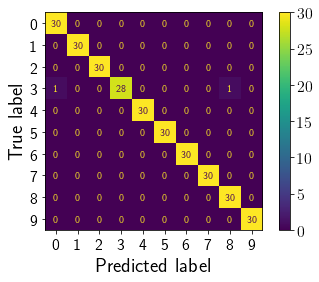

In [66]:
Y_true_train = []
Y_pred_train = []
mse_train = []
mse_test = []
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
print("MSE training: %f\n" % (np.mean(mse_train)))
plt.show()

Y_true_test = []
Y_pred_test = []
mse_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
print("MSE test: %f\n" % (np.mean(mse_test)))
plt.show()

Visualization of features from the training set

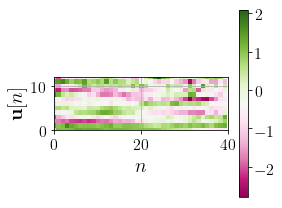

In [67]:
plt.figure(figsize=(4, 3))
im = plt.imshow(X_train_scaled[0].T,vmin=np.min(X_train_scaled[0]), vmax=np.max(X_train_scaled[0]))
plt.xlim([0,X_train_scaled[0].shape[0]])
plt.ylim([0, X_train_scaled[0].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('features_train.pdf')

Visualizations of features from the test set

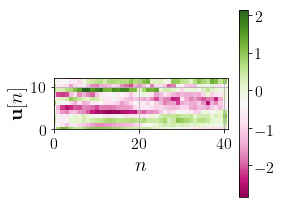

In [68]:
plt.figure(figsize=(4, 3))
im = plt.imshow(X_test_scaled[0].T,vmin=np.min(X_test_scaled[0]), vmax=np.max(X_test_scaled[0]))
plt.xlim([0, X_test[0].shape[0]])
plt.ylim([0, X_test[0].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('features_test.pdf')

Visualization of a reservoir state from the training set

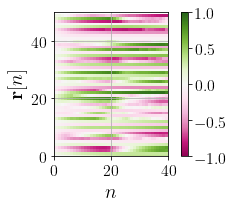

In [69]:
_ = esn.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_rand_train.pdf')

Visualization of a reservoir state from the test set

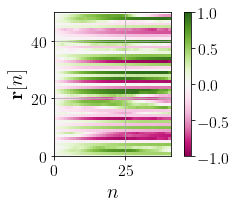

In [70]:
_ = esn.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_rand_test.pdf')

Random experiments

In [20]:
for rs in range(20):
    print("Train the ESN model...")
    kmeans = MiniBatchKMeans(n_clusters=500, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=0)
    kmeans.fit(X=np.vstack(X_train_scaled))
    base_esn = ESNRegressor(k_in=10, input_scaling=0.7, spectral_radius=0.7, bias=1.3, leakage=0.1, reservoir_size=500,
                            k_res=5, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                            bi_directional=False, solver='ridge', beta=1e-3, random_state=rs)
    w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
    esn = clone(base_esn)
    esn.initialize_from_outside(y=enc.transform(np.asarray(y_train[0]).reshape(-1, 1)), n_features=X_train[0].shape[0], 
                                input_weights=w_in, reservoir_weights=None, bias_weights=None)
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, update_output_weights=False)
    esn.finalize()
    print("... done!")
    Y_true_train = []
    Y_pred_train = []
    mse_train = []
    mse_test = []
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
    print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
    print("MSE training: %f\n" % (np.mean(mse_train)))
    
    Y_true_test = []
    Y_pred_test = []
    mse_test = []
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
    print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
    print("MSE test: %f\n" % (np.mean(mse_test)))


Train the ESN model...


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=0, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9448818898 1.0000000000 0.9716599190       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  1.0000000000 0.9916666667 0.9958158996       240
           3  0.9956331878 0.9500000000 0.9722814499       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9872881356 0.9708333333 0.9789915966       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795918367 1.0000000000 0.9896907216       240
           9  0.9958333333 0.9958333333 0.9958333333       240

    accuracy                      0.9895833333      2400
   macro avg  0.9899079006 0.9895833333 0.9895922135      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=1, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9600000000 1.0000000000 0.9795918367       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9583333333 0.9787234043       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9872340426 0.9666666667 0.9768421053       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9756097561 1.0000000000 0.9876543210       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9912500000      2400
   macro avg  0.9914545043 0.9912500000 0.9912381880      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=2, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9876543210 1.0000000000 0.9937888199       240
           3  1.0000000000 0.9541666667 0.9765458422       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9872340426 0.9666666667 0.9768421053       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9835390947 0.9958333333 0.9896480331       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9904166667      2400
   macro avg  0.9906269279 0.9904166667 0.9903991809      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=3, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  0.9958158996 0.9916666667 0.9937369520       240
           3  0.9956331878 0.9500000000 0.9722814499       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9834024896 0.9875000000 0.9854469854       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9917012448 0.9958333333 0.9937629938       240
           9  0.9917012448 0.9958333333 0.9937629938       240

    accuracy                      0.9900000000      2400
   macro avg  0.9901911787 0.9900000000 0.9899895335      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=4, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9338521401 1.0000000000 0.9657947686       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  1.0000000000 0.9333333333 0.9655172414       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9873417722 0.9750000000 0.9811320755       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9836065574 1.0000000000 0.9917355372       240
           9  0.9958333333 0.9958333333 0.9958333333       240

    accuracy                      0.9887500000      2400
   macro avg  0.9892317759 0.9887500000 0.9887495504      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=5, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9638554217 1.0000000000 0.9815950920       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  1.0000000000 1.0000000000 1.0000000000       240
           3  0.9956709957 0.9583333333 0.9766454352       240
           4  0.9958333333 0.9958333333 0.9958333333       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9790794979 0.9750000000 0.9770354906       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9794238683 0.9916666667 0.9855072464       240
           9  1.0000000000 1.0000000000 1.0000000000       240

    accuracy                      0.9904166667      2400
   macro avg  0.9905494916 0.9904166667 0.9904090502      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=6, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9411764706 1.0000000000 0.9696969697       240
           1  0.9957983193 0.9875000000 0.9916317992       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9416666667 0.9699570815       240
           4  0.9958333333 0.9958333333 0.9958333333       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9915611814 0.9791666667 0.9853249476       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9876543210 1.0000000000 0.9937888199       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9895833333      2400
   macro avg  0.9899609785 0.9895833333 0.9895820471      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=7, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9486166008 1.0000000000 0.9736308316       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9416666667 0.9699570815       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9872881356 0.9708333333 0.9789915966       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9715447154 0.9958333333 0.9835390947       240
           9  0.9958333333 0.9958333333 0.9958333333       240

    accuracy                      0.9891666667      2400
   macro avg  0.9894984030 0.9891666667 0.9891522151      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=8, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  1.0000000000 0.9875000000 0.9937106918       240
           2  1.0000000000 0.9958333333 0.9979123173       240
           3  1.0000000000 0.9625000000 0.9808917197       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9873417722 0.9750000000 0.9811320755       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9908333333      2400
   macro avg  0.9910577135 0.9908333333 0.9908425745      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=9, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  0.9958333333 0.9958333333 0.9958333333       240
           2  0.9957983193 0.9875000000 0.9916317992       240
           3  0.9913419913 0.9541666667 0.9723991507       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9874476987 0.9833333333 0.9853862213       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9876543210 1.0000000000 0.9937888199       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9908333333      2400
   macro avg  0.9910101585 0.9908333333 0.9908285281      2400
wei

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=10, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9448818898 1.0000000000 0.9716599190       240
           1  0.9958333333 0.9958333333 0.9958333333       240
           2  0.9917012448 0.9958333333 0.9937629938       240
           3  1.0000000000 0.9416666667 0.9699570815       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9872340426 0.9666666667 0.9768421053       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9755102041 0.9958333333 0.9855670103       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9883333333      2400
   macro avg  0.9886827237 0.9883333333 0.9883192710      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=11, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9600000000 1.0000000000 0.9795918367       240
           1  1.0000000000 0.9916666667 0.9958158996       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  0.9956521739 0.9541666667 0.9744680851       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9915966387 0.9833333333 0.9874476987       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9836065574 1.0000000000 0.9917355372       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9916666667      2400
   macro avg  0.9918389948 0.9916666667 0.9916550286      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=12, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9411764706 1.0000000000 0.9696969697       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  1.0000000000 0.9958333333 0.9979123173       240
           3  1.0000000000 0.9541666667 0.9765458422       240
           4  0.9958333333 0.9958333333 0.9958333333       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9872340426 0.9666666667 0.9768421053       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9891666667      2400
   macro avg  0.9895418565 0.9891666667 0.9891907723      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=13, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9448818898 1.0000000000 0.9716599190       240
           1  1.0000000000 0.9875000000 0.9937106918       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  0.9956331878 0.9500000000 0.9722814499       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9914529915 0.9666666667 0.9789029536       240
           7  0.9958158996 0.9916666667 0.9937369520       240
           8  0.9836065574 1.0000000000 0.9917355372       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9891666667      2400
   macro avg  0.9894810019 0.9891666667 0.9891632457      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=14, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9486166008 1.0000000000 0.9736308316       240
           1  1.0000000000 0.9875000000 0.9937106918       240
           2  0.9917012448 0.9958333333 0.9937629938       240
           3  1.0000000000 0.9500000000 0.9743589744       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9914893617 0.9708333333 0.9810526316       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795918367 1.0000000000 0.9896907216       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9895833333      2400
   macro avg  0.9898985204 0.9895833333 0.9895794365      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=15, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9523809524 1.0000000000 0.9756097561       240
           1  1.0000000000 0.9916666667 0.9958158996       240
           2  0.9958333333 0.9958333333 0.9958333333       240
           3  1.0000000000 0.9541666667 0.9765458422       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9873417722 0.9750000000 0.9811320755       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9917355372 1.0000000000 0.9958506224       240

    accuracy                      0.9904166667      2400
   macro avg  0.9906799792 0.9904166667 0.9904206734      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=16, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9523809524 1.0000000000 0.9756097561       240
           1  1.0000000000 0.9916666667 0.9958158996       240
           2  0.9958158996 0.9916666667 0.9937369520       240
           3  0.9956521739 0.9541666667 0.9744680851       240
           4  0.9958506224 1.0000000000 0.9979209979       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9831223629 0.9708333333 0.9769392034       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9795081967 0.9958333333 0.9876033058       240
           9  0.9958333333 0.9958333333 0.9958333333       240

    accuracy                      0.9891666667      2400
   macro avg  0.9894014164 0.9891666667 0.9891664431      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=17, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9561752988 1.0000000000 0.9775967413       240
           1  0.9958333333 0.9958333333 0.9958333333       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9500000000 0.9743589744       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9875000000 0.9875000000 0.9875000000       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9917355372 1.0000000000 0.9958506224       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9920833333      2400
   macro avg  0.9922945414 0.9920833333 0.9920709884      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=18, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9486166008 1.0000000000 0.9736308316       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  1.0000000000 0.9958333333 0.9979123173       240
           3  0.9913043478 0.9500000000 0.9702127660       240
           4  1.0000000000 0.9958333333 0.9979123173       240
           5  0.9958506224 1.0000000000 0.9979209979       240
           6  0.9874476987 0.9833333333 0.9853862213       240
           7  1.0000000000 0.9875000000 0.9937106918       240
           8  0.9876033058 0.9958333333 0.9917012448       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9900000000      2400
   macro avg  0.9902489098 0.9900000000 0.9900045338      2400
we

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=19, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9523809524 1.0000000000 0.9756097561       240
           1  0.9958158996 0.9916666667 0.9937369520       240
           2  0.9958158996 0.9916666667 0.9937369520       240
           3  0.9956140351 0.9458333333 0.9700854701       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9792531120 0.9833333333 0.9812889813       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9876033058 0.9958333333 0.9917012448       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9900000000      2400
   macro avg  0.9902333827 0.9900000000 0.9899896254      2400
we

K-Means Clustering

In [10]:
kmeans = MiniBatchKMeans(n_clusters=500, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=1, random_state=0)
kmeans.fit(X=np.vstack(X_train_scaled))

Init 1/3 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/3: 327.224175
Init 2/3 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Inertia for init 2/3: 274.447121
Init 3/3 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Inertia for init 3/3: 331.283465
Minibatch iteration 1/106900: mean batch inertia: 3.725833, ewa inertia: 3.725833 
Minibatch iteration 2/106900: mean batch inertia: 3.881756, ewa inertia: 3.726124 
Minibatch iteration 3/106900: mean batch inertia: 3.681032, ewa inertia: 3.726040 
Minibatch iteration 4/106900: mean batch inertia: 3.379444, ewa inertia: 3.725391 
Minibatch iteration 5/106900: mean batch inertia: 3.633030, ewa inertia: 3.725219 
Minibatch iteration 6/106900: mean batch inertia: 3.638565, ewa inertia: 3.725056 
Minibatch iteration 7/106900: mean batch inertia: 3.933620, ewa inertia: 3.725447 
Minibatch iteration 8/106900: mean batch inertia: 3.492223, ewa inertia: 3.725010 
Minibatch iteration 9/106900: mean batch inertia: 4.036831, ewa inertia: 3.725594 
Minibatch iteration 10/106900: mean batch inertia: 3.679328, ewa inertia: 3.725507 
Minibatch iteration 11/106900: mean batch inertia: 3.261993, ewa inertia: 3.724640 
Minibatch iteration 12/106900: mean batch inertia: 3

Minibatch iteration 194/106900: mean batch inertia: 2.950571, ewa inertia: 3.530287 
Minibatch iteration 195/106900: mean batch inertia: 2.732824, ewa inertia: 3.528794 
Minibatch iteration 196/106900: mean batch inertia: 2.972628, ewa inertia: 3.527753 
Minibatch iteration 197/106900: mean batch inertia: 3.021305, ewa inertia: 3.526805 
Minibatch iteration 198/106900: mean batch inertia: 2.727923, ewa inertia: 3.525310 
Minibatch iteration 199/106900: mean batch inertia: 3.056546, ewa inertia: 3.524433 
Minibatch iteration 200/106900: mean batch inertia: 2.670399, ewa inertia: 3.522835 
Minibatch iteration 201/106900: mean batch inertia: 2.933316, ewa inertia: 3.521731 
Minibatch iteration 202/106900: mean batch inertia: 3.081998, ewa inertia: 3.520908 
Minibatch iteration 203/106900: mean batch inertia: 2.777354, ewa inertia: 3.519517 
Minibatch iteration 204/106900: mean batch inertia: 3.041628, ewa inertia: 3.518622 
Minibatch iteration 205/106900: mean batch inertia: 2.973128, ewa

Minibatch iteration 386/106900: mean batch inertia: 2.970527, ewa inertia: 3.327961 
Minibatch iteration 387/106900: mean batch inertia: 2.736049, ewa inertia: 3.326853 
Minibatch iteration 388/106900: mean batch inertia: 2.990517, ewa inertia: 3.326224 
Minibatch iteration 389/106900: mean batch inertia: 2.959426, ewa inertia: 3.325537 
Minibatch iteration 390/106900: mean batch inertia: 2.836729, ewa inertia: 3.324622 
Minibatch iteration 391/106900: mean batch inertia: 3.079814, ewa inertia: 3.324164 
Minibatch iteration 392/106900: mean batch inertia: 2.888024, ewa inertia: 3.323348 
Minibatch iteration 393/106900: mean batch inertia: 2.811433, ewa inertia: 3.322390 
Minibatch iteration 394/106900: mean batch inertia: 2.628892, ewa inertia: 3.321092 
Minibatch iteration 395/106900: mean batch inertia: 2.663553, ewa inertia: 3.319861 
Minibatch iteration 396/106900: mean batch inertia: 2.711915, ewa inertia: 3.318724 
Minibatch iteration 397/106900: mean batch inertia: 2.959427, ewa

Minibatch iteration 578/106900: mean batch inertia: 2.835917, ewa inertia: 3.177061 
Minibatch iteration 579/106900: mean batch inertia: 2.694069, ewa inertia: 3.176157 
Minibatch iteration 580/106900: mean batch inertia: 2.895413, ewa inertia: 3.175632 
Minibatch iteration 581/106900: mean batch inertia: 2.910710, ewa inertia: 3.175136 
Minibatch iteration 582/106900: mean batch inertia: 2.764284, ewa inertia: 3.174367 
Minibatch iteration 583/106900: mean batch inertia: 2.932609, ewa inertia: 3.173915 
Minibatch iteration 584/106900: mean batch inertia: 2.956162, ewa inertia: 3.173507 
Minibatch iteration 585/106900: mean batch inertia: 2.728097, ewa inertia: 3.172674 
Minibatch iteration 586/106900: mean batch inertia: 2.816563, ewa inertia: 3.172007 
Minibatch iteration 587/106900: mean batch inertia: 2.701245, ewa inertia: 3.171126 
Minibatch iteration 588/106900: mean batch inertia: 2.910885, ewa inertia: 3.170639 
Minibatch iteration 589/106900: mean batch inertia: 2.837063, ewa

Minibatch iteration 770/106900: mean batch inertia: 2.827748, ewa inertia: 3.060150 
Minibatch iteration 771/106900: mean batch inertia: 3.000680, ewa inertia: 3.060039 
Minibatch iteration 772/106900: mean batch inertia: 2.698309, ewa inertia: 3.059362 
Minibatch iteration 773/106900: mean batch inertia: 2.996556, ewa inertia: 3.059244 
Minibatch iteration 774/106900: mean batch inertia: 2.877715, ewa inertia: 3.058905 
Minibatch iteration 775/106900: mean batch inertia: 2.697896, ewa inertia: 3.058229 
Minibatch iteration 776/106900: mean batch inertia: 2.732901, ewa inertia: 3.057620 
Minibatch iteration 777/106900: mean batch inertia: 2.549272, ewa inertia: 3.056669 
Minibatch iteration 778/106900: mean batch inertia: 2.807376, ewa inertia: 3.056202 
Minibatch iteration 779/106900: mean batch inertia: 2.737647, ewa inertia: 3.055606 
Minibatch iteration 780/106900: mean batch inertia: 2.611015, ewa inertia: 3.054774 
Minibatch iteration 781/106900: mean batch inertia: 2.735589, ewa

Minibatch iteration 962/106900: mean batch inertia: 2.924692, ewa inertia: 2.977771 
Minibatch iteration 963/106900: mean batch inertia: 2.820049, ewa inertia: 2.977475 
Minibatch iteration 964/106900: mean batch inertia: 3.142878, ewa inertia: 2.977785 
Minibatch iteration 965/106900: mean batch inertia: 2.665911, ewa inertia: 2.977201 
Minibatch iteration 966/106900: mean batch inertia: 2.777601, ewa inertia: 2.976828 
Minibatch iteration 967/106900: mean batch inertia: 2.809060, ewa inertia: 2.976514 
Minibatch iteration 968/106900: mean batch inertia: 3.019453, ewa inertia: 2.976594 
Minibatch iteration 969/106900: mean batch inertia: 2.858465, ewa inertia: 2.976373 
Minibatch iteration 970/106900: mean batch inertia: 2.740656, ewa inertia: 2.975932 
Minibatch iteration 971/106900: mean batch inertia: 2.851166, ewa inertia: 2.975698 
Minibatch iteration 972/106900: mean batch inertia: 2.509451, ewa inertia: 2.974826 
Minibatch iteration 973/106900: mean batch inertia: 2.555361, ewa

Minibatch iteration 1152/106900: mean batch inertia: 2.885568, ewa inertia: 2.910632 
Minibatch iteration 1153/106900: mean batch inertia: 2.569977, ewa inertia: 2.909995 
Minibatch iteration 1154/106900: mean batch inertia: 2.626463, ewa inertia: 2.909464 
Minibatch iteration 1155/106900: mean batch inertia: 2.856202, ewa inertia: 2.909364 
Minibatch iteration 1156/106900: mean batch inertia: 2.853681, ewa inertia: 2.909260 
Minibatch iteration 1157/106900: mean batch inertia: 2.557926, ewa inertia: 2.908603 
Minibatch iteration 1158/106900: mean batch inertia: 2.563618, ewa inertia: 2.907957 
Minibatch iteration 1159/106900: mean batch inertia: 2.945153, ewa inertia: 2.908027 
Minibatch iteration 1160/106900: mean batch inertia: 2.466666, ewa inertia: 2.907201 
Minibatch iteration 1161/106900: mean batch inertia: 2.782080, ewa inertia: 2.906966 
Minibatch iteration 1162/106900: mean batch inertia: 2.528534, ewa inertia: 2.906258 
Minibatch iteration 1163/106900: mean batch inertia: 2

Minibatch iteration 1342/106900: mean batch inertia: 2.912993, ewa inertia: 2.866648 
Minibatch iteration 1343/106900: mean batch inertia: 2.706227, ewa inertia: 2.866348 
Minibatch iteration 1344/106900: mean batch inertia: 2.817807, ewa inertia: 2.866257 
Minibatch iteration 1345/106900: mean batch inertia: 2.831794, ewa inertia: 2.866193 
Minibatch iteration 1346/106900: mean batch inertia: 2.798376, ewa inertia: 2.866066 
Minibatch iteration 1347/106900: mean batch inertia: 2.878440, ewa inertia: 2.866089 
Minibatch iteration 1348/106900: mean batch inertia: 2.780074, ewa inertia: 2.865928 
Minibatch iteration 1349/106900: mean batch inertia: 2.856478, ewa inertia: 2.865910 
Minibatch iteration 1350/106900: mean batch inertia: 2.647220, ewa inertia: 2.865501 
Minibatch iteration 1351/106900: mean batch inertia: 2.791776, ewa inertia: 2.865363 
Minibatch iteration 1352/106900: mean batch inertia: 2.798901, ewa inertia: 2.865239 
Minibatch iteration 1353/106900: mean batch inertia: 2

Minibatch iteration 1532/106900: mean batch inertia: 2.588769, ewa inertia: 2.833555 
Minibatch iteration 1533/106900: mean batch inertia: 2.678521, ewa inertia: 2.833265 
Minibatch iteration 1534/106900: mean batch inertia: 2.941107, ewa inertia: 2.833467 
Minibatch iteration 1535/106900: mean batch inertia: 2.704483, ewa inertia: 2.833225 
Minibatch iteration 1536/106900: mean batch inertia: 2.835458, ewa inertia: 2.833229 
Minibatch iteration 1537/106900: mean batch inertia: 2.682331, ewa inertia: 2.832947 
Minibatch iteration 1538/106900: mean batch inertia: 2.795249, ewa inertia: 2.832876 
Minibatch iteration 1539/106900: mean batch inertia: 2.607620, ewa inertia: 2.832455 
Minibatch iteration 1540/106900: mean batch inertia: 2.593729, ewa inertia: 2.832008 
Minibatch iteration 1541/106900: mean batch inertia: 2.709517, ewa inertia: 2.831779 
Minibatch iteration 1542/106900: mean batch inertia: 2.718019, ewa inertia: 2.831566 
Minibatch iteration 1543/106900: mean batch inertia: 2

Minibatch iteration 1722/106900: mean batch inertia: 2.549122, ewa inertia: 2.806137 
Minibatch iteration 1723/106900: mean batch inertia: 2.491666, ewa inertia: 2.805548 
Minibatch iteration 1724/106900: mean batch inertia: 2.576633, ewa inertia: 2.805120 
Minibatch iteration 1725/106900: mean batch inertia: 3.016227, ewa inertia: 2.805515 
Minibatch iteration 1726/106900: mean batch inertia: 2.775762, ewa inertia: 2.805459 
Minibatch iteration 1727/106900: mean batch inertia: 2.822214, ewa inertia: 2.805490 
Minibatch iteration 1728/106900: mean batch inertia: 2.926972, ewa inertia: 2.805718 
Minibatch iteration 1729/106900: mean batch inertia: 2.778735, ewa inertia: 2.805667 
Minibatch iteration 1730/106900: mean batch inertia: 2.689294, ewa inertia: 2.805449 
Minibatch iteration 1731/106900: mean batch inertia: 2.590887, ewa inertia: 2.805048 
Minibatch iteration 1732/106900: mean batch inertia: 2.915359, ewa inertia: 2.805254 
Minibatch iteration 1733/106900: mean batch inertia: 2

Minibatch iteration 1912/106900: mean batch inertia: 2.674718, ewa inertia: 2.786308 
Minibatch iteration 1913/106900: mean batch inertia: 2.655516, ewa inertia: 2.786064 
Minibatch iteration 1914/106900: mean batch inertia: 2.549681, ewa inertia: 2.785621 
Minibatch iteration 1915/106900: mean batch inertia: 2.769732, ewa inertia: 2.785591 
Minibatch iteration 1916/106900: mean batch inertia: 2.925631, ewa inertia: 2.785853 
Minibatch iteration 1917/106900: mean batch inertia: 2.693530, ewa inertia: 2.785681 
Minibatch iteration 1918/106900: mean batch inertia: 2.563041, ewa inertia: 2.785264 
Minibatch iteration 1919/106900: mean batch inertia: 2.609200, ewa inertia: 2.784934 
Minibatch iteration 1920/106900: mean batch inertia: 2.683285, ewa inertia: 2.784744 
Minibatch iteration 1921/106900: mean batch inertia: 3.164849, ewa inertia: 2.785456 
Minibatch iteration 1922/106900: mean batch inertia: 2.933484, ewa inertia: 2.785733 
Minibatch iteration 1923/106900: mean batch inertia: 2

Minibatch iteration 2102/106900: mean batch inertia: 2.741003, ewa inertia: 2.771133 
Minibatch iteration 2103/106900: mean batch inertia: 2.679883, ewa inertia: 2.770962 
Minibatch iteration 2104/106900: mean batch inertia: 2.772136, ewa inertia: 2.770964 
Minibatch iteration 2105/106900: mean batch inertia: 2.809393, ewa inertia: 2.771036 
Minibatch iteration 2106/106900: mean batch inertia: 2.904849, ewa inertia: 2.771287 
Minibatch iteration 2107/106900: mean batch inertia: 2.636967, ewa inertia: 2.771035 
Minibatch iteration 2108/106900: mean batch inertia: 2.562195, ewa inertia: 2.770645 
Minibatch iteration 2109/106900: mean batch inertia: 2.597898, ewa inertia: 2.770321 
Minibatch iteration 2110/106900: mean batch inertia: 2.640119, ewa inertia: 2.770078 
Minibatch iteration 2111/106900: mean batch inertia: 2.828428, ewa inertia: 2.770187 
Minibatch iteration 2112/106900: mean batch inertia: 2.929184, ewa inertia: 2.770484 
Minibatch iteration 2113/106900: mean batch inertia: 2

Minibatch iteration 2292/106900: mean batch inertia: 2.583085, ewa inertia: 2.762478 
Minibatch iteration 2293/106900: mean batch inertia: 2.871105, ewa inertia: 2.762682 
Minibatch iteration 2294/106900: mean batch inertia: 3.012619, ewa inertia: 2.763149 
Minibatch iteration 2295/106900: mean batch inertia: 2.738732, ewa inertia: 2.763104 
Minibatch iteration 2296/106900: mean batch inertia: 2.879395, ewa inertia: 2.763321 
Minibatch iteration 2297/106900: mean batch inertia: 2.749603, ewa inertia: 2.763296 
Minibatch iteration 2298/106900: mean batch inertia: 2.772908, ewa inertia: 2.763314 
Minibatch iteration 2299/106900: mean batch inertia: 2.719092, ewa inertia: 2.763231 
Minibatch iteration 2300/106900: mean batch inertia: 2.918058, ewa inertia: 2.763521 
Minibatch iteration 2301/106900: mean batch inertia: 2.457209, ewa inertia: 2.762947 
Minibatch iteration 2302/106900: mean batch inertia: 3.030674, ewa inertia: 2.763449 
Minibatch iteration 2303/106900: mean batch inertia: 2

Minibatch iteration 2482/106900: mean batch inertia: 2.738364, ewa inertia: 2.747707 
Minibatch iteration 2483/106900: mean batch inertia: 2.903885, ewa inertia: 2.748000 
Minibatch iteration 2484/106900: mean batch inertia: 2.872766, ewa inertia: 2.748233 
Minibatch iteration 2485/106900: mean batch inertia: 2.752231, ewa inertia: 2.748241 
Minibatch iteration 2486/106900: mean batch inertia: 2.627978, ewa inertia: 2.748016 
Minibatch iteration 2487/106900: mean batch inertia: 2.958375, ewa inertia: 2.748409 
Minibatch iteration 2488/106900: mean batch inertia: 2.571538, ewa inertia: 2.748078 
Minibatch iteration 2489/106900: mean batch inertia: 2.919982, ewa inertia: 2.748400 
Minibatch iteration 2490/106900: mean batch inertia: 2.701614, ewa inertia: 2.748312 
Minibatch iteration 2491/106900: mean batch inertia: 2.737407, ewa inertia: 2.748292 
Minibatch iteration 2492/106900: mean batch inertia: 2.811082, ewa inertia: 2.748409 
Minibatch iteration 2493/106900: mean batch inertia: 2

MiniBatchKMeans(max_no_improvement=50, n_clusters=500, random_state=0,
                reassignment_ratio=0, verbose=1)

Compute distance to labels

In [11]:
new_train_features = [kmeans.transform(X) for X in X_train_scaled]
new_test_features = [kmeans.transform(X) for X in X_test_scaled]

Visualization

NameError: name 'esn' is not defined

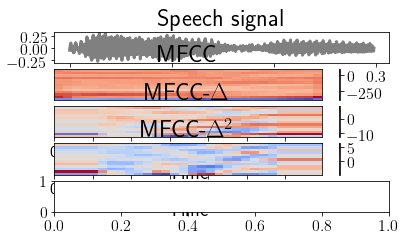

In [12]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(6, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(6, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(6, 1, 3)
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(6, 1, 4)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.subplot(6, 1, 5)
_ = esn.predict(X=X_test[0], keep_reservoir_state=True)
librosa.display.specshow(esn.reservoir_state.T, x_axis='time')
plt.colorbar()
plt.subplot(6, 1, 6)
librosa.display.specshow(new_test_features[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.show()

In [82]:
base_esn = ESNRegressor(k_in=10, input_scaling=0.7, spectral_radius=0.7, bias=1.3, leakage=0.1, reservoir_size=500,
                        k_res=5, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                        bi_directional=False, solver='ridge', beta=1e-3, random_state=1)
esn = clone(base_esn)
new_input_weights = kmeans.cluster_centers_
# To compute the norm of the cluster centers, use the following line:
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
print(w_in.shape)
esn.initialize_from_outside(y=enc.transform(np.asarray(y_train[0]).reshape(-1, 1)), n_features=X_train[0].shape[0], 
                            input_weights=w_in, reservoir_weights=None, bias_weights=None)

(500, 13)


In [83]:
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, update_output_weights=False)
        pbar.update(1)
esn.finalize()
print("done!")

Train the ESN model...


100%|█████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:13<00:00, 181.56it/s]


done!


Test

100%|█████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:05<00:00, 459.06it/s]


Classification training report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=1, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  0.9600000000 1.0000000000 0.9795918367       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9583333333 0.9787234043       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9872340426 0.9666666667 0.9768421053       240
           7  1.0000000000 0.9916666667 0.9958158996       240
           8  0.9756097561 1.0000000000 0.9876543210       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9912500000      2400
   macro avg  0.9914545043 0.9912500000 0.9912381880      2400
weighted avg 

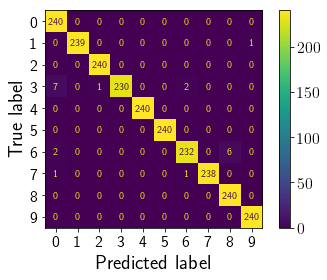

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 481.54it/s]


Classification test report for estimator ESNRegressor(beta=0.001, bias=1.3, input_scaling=0.7, k_in=10, k_res=5,
             leakage=0.1, random_state=1, spectral_radius=0.7):
              precision    recall  f1-score   support

           0  1.0000000000 1.0000000000 1.0000000000        30
           1  1.0000000000 1.0000000000 1.0000000000        30
           2  1.0000000000 1.0000000000 1.0000000000        30
           3  1.0000000000 0.9333333333 0.9655172414        30
           4  1.0000000000 1.0000000000 1.0000000000        30
           5  1.0000000000 1.0000000000 1.0000000000        30
           6  1.0000000000 1.0000000000 1.0000000000        30
           7  0.9677419355 1.0000000000 0.9836065574        30
           8  0.9677419355 1.0000000000 0.9836065574        30
           9  1.0000000000 1.0000000000 1.0000000000        30

    accuracy                      0.9933333333       300
   macro avg  0.9935483871 0.9933333333 0.9932730356       300
weighted avg  0.9

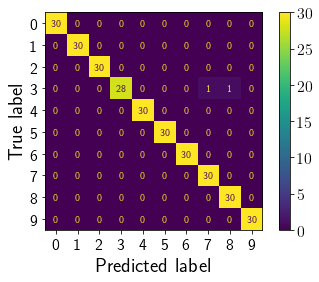

In [84]:
Y_true_train = []
Y_pred_train = []
mse_train = []
mse_test = []
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
print("MSE training: %f\n" % (np.mean(mse_train)))
plt.show()

Y_true_test = []
Y_pred_test = []
mse_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
print("MSE test: %f\n" % (np.mean(mse_test)))
plt.show()

Visualization of a reservoir state from the training set

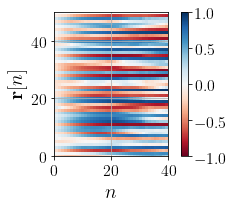

In [87]:
_ = esn.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1, cmap='RdBu')
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_kmeans_train.pdf')

Visualization of a reservoir state from the test set

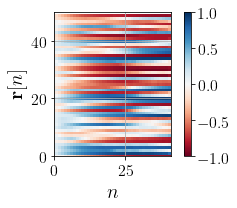

In [88]:
_ = esn.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1, cmap='RdBu')
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_kmeans_test.pdf')

Increase the reservoir size

In [40]:
base_esn = ESNRegressor(k_in=10, input_scaling=1.2, spectral_radius=0.6, bias=0.7, leakage=0.1, reservoir_size=4000,
                        k_res=5, reservoir_activation='tanh', teacher_scaling=1.0, teacher_shift=0.0,
                        bi_directional=False, solver='ridge', beta=1e-3, random_state=1)
esn = clone(base_esn)
new_input_weights = kmeans.cluster_centers_
# To compute the norm of the cluster centers, use the following line:
w_in = np.pad(np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None]), ((0, 3500), (0, 0)), mode='constant', constant_values=0)
print(w_in.shape)
esn.initialize_from_outside(y=enc.transform(np.asarray(y_train[0]).reshape(-1, 1)), n_features=X_train[0].shape[0], 
                            input_weights=w_in, reservoir_weights=None, bias_weights=None)

(4000, 13)


In [41]:
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y, update_output_weights=False)
        pbar.update(1)
esn.finalize()
print("done!")

Train the ESN model...


100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [10:43<00:00,  3.99it/s]


done!


Test

100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:40<00:00, 58.82it/s]


Classification training report for estimator ESNRegressor(beta=0.001, bias=0.7, input_scaling=1.2, k_in=10, k_res=5,
             leakage=0.1, random_state=1, reservoir_size=4000,
             spectral_radius=0.6):
              precision    recall  f1-score   support

           0  0.9600000000 1.0000000000 0.9795918367       240
           1  1.0000000000 0.9958333333 0.9979123173       240
           2  0.9958506224 1.0000000000 0.9979209979       240
           3  1.0000000000 0.9625000000 0.9808917197       240
           4  1.0000000000 1.0000000000 1.0000000000       240
           5  1.0000000000 1.0000000000 1.0000000000       240
           6  0.9957627119 0.9791666667 0.9873949580       240
           7  1.0000000000 0.9958333333 0.9979123173       240
           8  0.9876543210 1.0000000000 0.9937888199       240
           9  0.9958506224 1.0000000000 0.9979209979       240

    accuracy                      0.9933333333      2400
   macro avg  0.9935118278 0.9933333333 0.

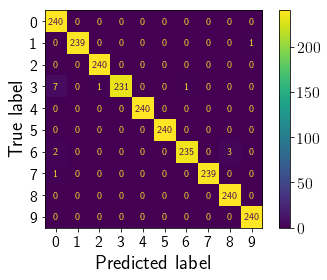

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 63.28it/s]


Classification test report for estimator ESNRegressor(beta=0.001, bias=0.7, input_scaling=1.2, k_in=10, k_res=5,
             leakage=0.1, random_state=1, reservoir_size=4000,
             spectral_radius=0.6):
              precision    recall  f1-score   support

           0  0.9677419355 1.0000000000 0.9836065574        30
           1  1.0000000000 1.0000000000 1.0000000000        30
           2  1.0000000000 1.0000000000 1.0000000000        30
           3  1.0000000000 0.9666666667 0.9830508475        30
           4  1.0000000000 1.0000000000 1.0000000000        30
           5  1.0000000000 1.0000000000 1.0000000000        30
           6  1.0000000000 1.0000000000 1.0000000000        30
           7  1.0000000000 1.0000000000 1.0000000000        30
           8  1.0000000000 1.0000000000 1.0000000000        30
           9  1.0000000000 1.0000000000 1.0000000000        30

    accuracy                      0.9966666667       300
   macro avg  0.9967741935 0.9966666667 0.9966

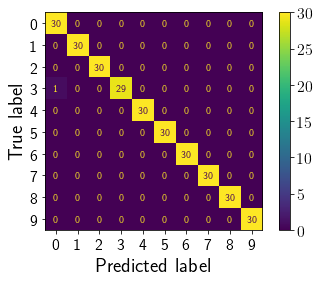

In [42]:
Y_true_train = []
Y_pred_train = []
mse_train = []
mse_test = []
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
print("MSE training: %f\n" % (np.mean(mse_train)))
plt.show()

Y_true_test = []
Y_pred_test = []
mse_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X, keep_reservoir_state=False)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
print("MSE test: %f\n" % (np.mean(mse_test)))
plt.show()

Visualization of a reservoir state from the training set

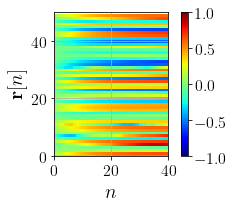

In [43]:
_ = esn.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('reservoir_size_kmeans_train.pdf')

Visualization of a reservoir state from the test set

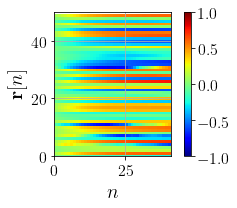

In [44]:
_ = esn.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('reservoir_size_kmeans_test.pdf')

Functions to fit KMeans and KMedoids for different settings (K, minibatch)

In [11]:
def fit_k_means(k, mini_batch=False, X=np.ndarray):
    if mini_batch:
        kmeans = MiniBatchKMeans(n_clusters=k, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=0)
    else:
        kmeans = MiniBatchKMeans(n_clusters=k, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=0)
    kmeans.fit(X=np.vstack(X_train_scaled))
    return silhouette_score(np.vstack(X_train_scaled), kmeans.labels_)

def fit_k_medoids(k):
    kmedoids = KMedoids(n_clusters=k, metric='euclidean',init='k-medoids++', max_iter=300, random_state=0)
    kmedoids.fit(X=np.vstack(X_train_scaled))
    return kmedoids.inertia_


Sweep along various $K$ and compare $K$-means, Mini-batch $K$-means and $K$-medoids

In [ ]:
# inertias_k_means = Parallel(n_jobs=-1, verbose=50)(delayed(fit_k_means)(k, False) for k in range(10, 1001, 10))
silhouette_scores_k_means = [None] * len(range(2, 1001))
for k in range(2, 1001):
    print(k)
    silhouette_scores_k_means[k-2] = fit_k_means(k, True, X_train_scaled)
# inertias_k_medoids = Parallel(n_jobs=-1, verbose=50)(delayed(fit_k_medoids)(k) for k in range(10, 501, 10))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=301. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=301. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=301. Setting it to 3*k
  init_size=init_size)


302


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=302. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=302. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=302. Setting it to 3*k
  init_size=init_size)


303


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=303. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=303. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=303. Setting it to 3*k
  init_size=init_size)


304


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=304. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=304. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=304. Setting it to 3*k
  init_size=init_size)


305


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=305. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=305. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=305. Setting it to 3*k
  init_size=init_size)


306


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=306. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=306. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=306. Setting it to 3*k
  init_size=init_size)


307


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=307. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=307. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=307. Setting it to 3*k
  init_size=init_size)


308


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=308. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=308. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=308. Setting it to 3*k
  init_size=init_size)


309


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=309. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=309. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=309. Setting it to 3*k
  init_size=init_size)


310


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=310. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=310. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=310. Setting it to 3*k
  init_size=init_size)


311


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=311. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=311. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=311. Setting it to 3*k
  init_size=init_size)


312


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=312. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=312. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=312. Setting it to 3*k
  init_size=init_size)


313


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=313. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=313. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=313. Setting it to 3*k
  init_size=init_size)


314


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=314. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=314. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=314. Setting it to 3*k
  init_size=init_size)


315


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=315. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=315. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=315. Setting it to 3*k
  init_size=init_size)


316


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=316. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=316. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=316. Setting it to 3*k
  init_size=init_size)


317


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=317. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=317. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=317. Setting it to 3*k
  init_size=init_size)


318


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=318. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=318. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=318. Setting it to 3*k
  init_size=init_size)


319


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=319. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=319. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=319. Setting it to 3*k
  init_size=init_size)


320


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=320. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=320. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=320. Setting it to 3*k
  init_size=init_size)


321


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=321. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=321. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=321. Setting it to 3*k
  init_size=init_size)


322


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=322. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=322. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=322. Setting it to 3*k
  init_size=init_size)


323


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=323. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=323. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=323. Setting it to 3*k
  init_size=init_size)


324


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=324. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=324. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=324. Setting it to 3*k
  init_size=init_size)


325


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=325. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=325. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=325. Setting it to 3*k
  init_size=init_size)


326


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=326. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=326. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=326. Setting it to 3*k
  init_size=init_size)


327


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=327. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=327. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=327. Setting it to 3*k
  init_size=init_size)


328


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=328. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=328. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=328. Setting it to 3*k
  init_size=init_size)


329


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=329. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=329. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=329. Setting it to 3*k
  init_size=init_size)


330


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=330. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=330. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=330. Setting it to 3*k
  init_size=init_size)


331


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=331. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=331. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=331. Setting it to 3*k
  init_size=init_size)


332


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=332. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=332. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=332. Setting it to 3*k
  init_size=init_size)


333


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=333. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=333. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=333. Setting it to 3*k
  init_size=init_size)


334


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=334. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=334. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=334. Setting it to 3*k
  init_size=init_size)


335


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=335. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=335. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=335. Setting it to 3*k
  init_size=init_size)


336


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=336. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=336. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=336. Setting it to 3*k
  init_size=init_size)


337


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=337. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=337. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=337. Setting it to 3*k
  init_size=init_size)


338


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=338. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=338. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=338. Setting it to 3*k
  init_size=init_size)


339


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=339. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=339. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=339. Setting it to 3*k
  init_size=init_size)


340


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=340. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=340. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=340. Setting it to 3*k
  init_size=init_size)


341


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=341. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=341. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=341. Setting it to 3*k
  init_size=init_size)


342


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=342. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=342. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=342. Setting it to 3*k
  init_size=init_size)


343


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=343. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=343. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=343. Setting it to 3*k
  init_size=init_size)


344


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=344. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=344. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=344. Setting it to 3*k
  init_size=init_size)


345


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=345. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=345. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=345. Setting it to 3*k
  init_size=init_size)


346


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=346. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=346. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=346. Setting it to 3*k
  init_size=init_size)


347


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=347. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=347. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=347. Setting it to 3*k
  init_size=init_size)


348


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=348. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=348. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=348. Setting it to 3*k
  init_size=init_size)


349


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=349. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=349. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=349. Setting it to 3*k
  init_size=init_size)


350


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=350. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=350. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=350. Setting it to 3*k
  init_size=init_size)


351


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=351. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=351. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=351. Setting it to 3*k
  init_size=init_size)


352


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=352. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=352. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=352. Setting it to 3*k
  init_size=init_size)


353


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=353. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=353. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=353. Setting it to 3*k
  init_size=init_size)


354


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=354. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=354. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=354. Setting it to 3*k
  init_size=init_size)


355


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=355. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=355. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=355. Setting it to 3*k
  init_size=init_size)


356


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=356. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=356. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=356. Setting it to 3*k
  init_size=init_size)


357


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=357. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=357. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=357. Setting it to 3*k
  init_size=init_size)


358


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=358. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=358. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=358. Setting it to 3*k
  init_size=init_size)


359


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=359. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=359. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=359. Setting it to 3*k
  init_size=init_size)


360


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=360. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=360. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=360. Setting it to 3*k
  init_size=init_size)


361


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=361. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=361. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=361. Setting it to 3*k
  init_size=init_size)


362


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=362. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=362. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=362. Setting it to 3*k
  init_size=init_size)


363


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=363. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=363. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=363. Setting it to 3*k
  init_size=init_size)


364


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=364. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=364. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=364. Setting it to 3*k
  init_size=init_size)


365


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=365. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=365. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=365. Setting it to 3*k
  init_size=init_size)


366


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=366. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=366. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=366. Setting it to 3*k
  init_size=init_size)


367


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=367. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=367. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=367. Setting it to 3*k
  init_size=init_size)


368


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=368. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=368. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=368. Setting it to 3*k
  init_size=init_size)


369


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=369. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=369. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=369. Setting it to 3*k
  init_size=init_size)


370


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=370. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=370. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=370. Setting it to 3*k
  init_size=init_size)


371


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=371. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=371. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=371. Setting it to 3*k
  init_size=init_size)


372


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=372. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=372. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=372. Setting it to 3*k
  init_size=init_size)


373


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=373. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=373. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=373. Setting it to 3*k
  init_size=init_size)


374


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=374. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=374. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=374. Setting it to 3*k
  init_size=init_size)


375


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=375. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=375. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=375. Setting it to 3*k
  init_size=init_size)


376


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=376. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=376. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=376. Setting it to 3*k
  init_size=init_size)


377


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=377. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=377. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=377. Setting it to 3*k
  init_size=init_size)


378


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=378. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=378. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=378. Setting it to 3*k
  init_size=init_size)


379


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=379. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=379. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=379. Setting it to 3*k
  init_size=init_size)


380


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=380. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=380. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=380. Setting it to 3*k
  init_size=init_size)


381


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=381. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=381. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=381. Setting it to 3*k
  init_size=init_size)


382


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=382. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=382. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=382. Setting it to 3*k
  init_size=init_size)


383


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=383. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=383. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=383. Setting it to 3*k
  init_size=init_size)


384


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=384. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=384. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=384. Setting it to 3*k
  init_size=init_size)


385


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=385. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=385. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=385. Setting it to 3*k
  init_size=init_size)


386


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=386. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=386. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=386. Setting it to 3*k
  init_size=init_size)


387


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=387. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=387. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=387. Setting it to 3*k
  init_size=init_size)


388


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=388. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=388. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=388. Setting it to 3*k
  init_size=init_size)


389


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=389. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=389. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=389. Setting it to 3*k
  init_size=init_size)


390


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=390. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=390. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=390. Setting it to 3*k
  init_size=init_size)


391


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=391. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=391. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=391. Setting it to 3*k
  init_size=init_size)


392


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=392. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=392. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=392. Setting it to 3*k
  init_size=init_size)


393


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=393. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=393. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=393. Setting it to 3*k
  init_size=init_size)


394


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=394. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=394. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=394. Setting it to 3*k
  init_size=init_size)


395


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=395. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=395. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=395. Setting it to 3*k
  init_size=init_size)


396


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=396. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=396. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=396. Setting it to 3*k
  init_size=init_size)


397


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=397. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=397. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=397. Setting it to 3*k
  init_size=init_size)


398


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=398. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=398. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=398. Setting it to 3*k
  init_size=init_size)


399


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=399. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=399. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=399. Setting it to 3*k
  init_size=init_size)


400


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


401


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=401. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=401. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=401. Setting it to 3*k
  init_size=init_size)


402


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=402. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=402. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=402. Setting it to 3*k
  init_size=init_size)


403


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=403. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=403. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=403. Setting it to 3*k
  init_size=init_size)


404


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=404. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=404. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=404. Setting it to 3*k
  init_size=init_size)


405


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=405. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=405. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=405. Setting it to 3*k
  init_size=init_size)


406


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=406. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=406. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=406. Setting it to 3*k
  init_size=init_size)


407


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=407. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=407. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=407. Setting it to 3*k
  init_size=init_size)


408


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=408. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=408. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=408. Setting it to 3*k
  init_size=init_size)


409


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=409. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=409. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=409. Setting it to 3*k
  init_size=init_size)


410


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=410. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=410. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=410. Setting it to 3*k
  init_size=init_size)


411


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=411. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=411. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=411. Setting it to 3*k
  init_size=init_size)


412


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=412. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=412. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=412. Setting it to 3*k
  init_size=init_size)


413


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=413. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=413. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=413. Setting it to 3*k
  init_size=init_size)


414


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=414. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=414. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=414. Setting it to 3*k
  init_size=init_size)


415


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=415. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=415. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=415. Setting it to 3*k
  init_size=init_size)


416


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=416. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=416. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=416. Setting it to 3*k
  init_size=init_size)


417


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=417. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=417. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=417. Setting it to 3*k
  init_size=init_size)


418


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=418. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=418. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=418. Setting it to 3*k
  init_size=init_size)


419


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=419. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=419. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=419. Setting it to 3*k
  init_size=init_size)


420


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=420. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=420. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=420. Setting it to 3*k
  init_size=init_size)


421


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=421. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=421. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=421. Setting it to 3*k
  init_size=init_size)


422


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=422. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=422. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=422. Setting it to 3*k
  init_size=init_size)


423


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=423. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=423. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=423. Setting it to 3*k
  init_size=init_size)


424


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=424. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=424. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=424. Setting it to 3*k
  init_size=init_size)


425


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=425. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=425. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=425. Setting it to 3*k
  init_size=init_size)


426


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=426. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=426. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=426. Setting it to 3*k
  init_size=init_size)


427


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=427. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=427. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=427. Setting it to 3*k
  init_size=init_size)


428


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=428. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=428. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=428. Setting it to 3*k
  init_size=init_size)


429


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=429. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=429. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=429. Setting it to 3*k
  init_size=init_size)


430


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=430. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=430. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=430. Setting it to 3*k
  init_size=init_size)


431


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=431. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=431. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=431. Setting it to 3*k
  init_size=init_size)


432


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=432. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=432. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=432. Setting it to 3*k
  init_size=init_size)


433


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=433. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=433. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=433. Setting it to 3*k
  init_size=init_size)


434


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=434. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=434. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=434. Setting it to 3*k
  init_size=init_size)


435


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=435. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=435. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=435. Setting it to 3*k
  init_size=init_size)


436


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=436. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=436. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=436. Setting it to 3*k
  init_size=init_size)


437


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=437. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=437. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=437. Setting it to 3*k
  init_size=init_size)


438


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=438. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=438. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=438. Setting it to 3*k
  init_size=init_size)


439


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=439. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=439. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=439. Setting it to 3*k
  init_size=init_size)


440


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=440. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=440. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=440. Setting it to 3*k
  init_size=init_size)


441


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=441. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=441. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=441. Setting it to 3*k
  init_size=init_size)


442


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=442. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=442. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=442. Setting it to 3*k
  init_size=init_size)


443


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=443. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=443. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=443. Setting it to 3*k
  init_size=init_size)


444


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=444. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=444. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=444. Setting it to 3*k
  init_size=init_size)


445


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=445. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=445. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=445. Setting it to 3*k
  init_size=init_size)


446


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=446. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=446. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=446. Setting it to 3*k
  init_size=init_size)


447


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=447. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=447. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=447. Setting it to 3*k
  init_size=init_size)


448


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=448. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=448. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=448. Setting it to 3*k
  init_size=init_size)


449


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=449. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=449. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=449. Setting it to 3*k
  init_size=init_size)


450


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=450. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=450. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=450. Setting it to 3*k
  init_size=init_size)


451


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=451. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=451. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=451. Setting it to 3*k
  init_size=init_size)


452


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=452. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=452. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=452. Setting it to 3*k
  init_size=init_size)


453


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=453. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=453. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=453. Setting it to 3*k
  init_size=init_size)


454


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=454. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=454. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=454. Setting it to 3*k
  init_size=init_size)


455


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=455. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=455. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=455. Setting it to 3*k
  init_size=init_size)


456


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=456. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=456. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=456. Setting it to 3*k
  init_size=init_size)


457


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=457. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=457. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=457. Setting it to 3*k
  init_size=init_size)


458


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=458. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=458. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=458. Setting it to 3*k
  init_size=init_size)


459


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=459. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=459. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=459. Setting it to 3*k
  init_size=init_size)


460


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=460. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=460. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=460. Setting it to 3*k
  init_size=init_size)


461


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=461. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=461. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=461. Setting it to 3*k
  init_size=init_size)


462


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=462. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=462. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=462. Setting it to 3*k
  init_size=init_size)


463


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=463. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=463. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=463. Setting it to 3*k
  init_size=init_size)


464


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=464. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=464. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=464. Setting it to 3*k
  init_size=init_size)


465


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=465. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=465. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=465. Setting it to 3*k
  init_size=init_size)


466


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=466. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=466. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=466. Setting it to 3*k
  init_size=init_size)


467


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=467. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=467. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=467. Setting it to 3*k
  init_size=init_size)


468


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=468. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=468. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=468. Setting it to 3*k
  init_size=init_size)


469


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=469. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=469. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=469. Setting it to 3*k
  init_size=init_size)


470


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=470. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=470. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=470. Setting it to 3*k
  init_size=init_size)


471


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=471. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=471. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=471. Setting it to 3*k
  init_size=init_size)


472


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=472. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=472. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=472. Setting it to 3*k
  init_size=init_size)


473


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=473. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=473. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=473. Setting it to 3*k
  init_size=init_size)


474


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=474. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=474. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=474. Setting it to 3*k
  init_size=init_size)


475


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=475. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=475. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=475. Setting it to 3*k
  init_size=init_size)


476


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=476. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=476. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=476. Setting it to 3*k
  init_size=init_size)


477


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=477. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=477. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=477. Setting it to 3*k
  init_size=init_size)


478


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=478. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=478. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=478. Setting it to 3*k
  init_size=init_size)


479


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=479. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=479. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=479. Setting it to 3*k
  init_size=init_size)


480


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=480. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=480. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=480. Setting it to 3*k
  init_size=init_size)


481


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=481. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=481. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=481. Setting it to 3*k
  init_size=init_size)


482


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=482. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=482. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=482. Setting it to 3*k
  init_size=init_size)


483


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=483. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=483. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=483. Setting it to 3*k
  init_size=init_size)


484


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=484. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=484. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=484. Setting it to 3*k
  init_size=init_size)


485


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=485. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=485. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=485. Setting it to 3*k
  init_size=init_size)


486


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=486. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=486. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=486. Setting it to 3*k
  init_size=init_size)


487


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=487. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=487. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=487. Setting it to 3*k
  init_size=init_size)


488


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=488. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=488. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=488. Setting it to 3*k
  init_size=init_size)


489


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=489. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=489. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=489. Setting it to 3*k
  init_size=init_size)


490


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=490. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=490. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=490. Setting it to 3*k
  init_size=init_size)


491


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=491. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=491. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=491. Setting it to 3*k
  init_size=init_size)


492


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=492. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=492. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=492. Setting it to 3*k
  init_size=init_size)


493


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=493. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=493. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=493. Setting it to 3*k
  init_size=init_size)


494


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=494. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=494. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=494. Setting it to 3*k
  init_size=init_size)


495


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=495. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=495. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=495. Setting it to 3*k
  init_size=init_size)


496


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=496. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=496. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=496. Setting it to 3*k
  init_size=init_size)


497


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=497. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=497. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=497. Setting it to 3*k
  init_size=init_size)


498


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=498. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=498. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=498. Setting it to 3*k
  init_size=init_size)


499


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=499. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=499. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=499. Setting it to 3*k
  init_size=init_size)


500


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


501


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=501. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=501. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=501. Setting it to 3*k
  init_size=init_size)


502


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=502. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=502. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=502. Setting it to 3*k
  init_size=init_size)


503


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=503. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=503. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=503. Setting it to 3*k
  init_size=init_size)


504


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=504. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=504. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=504. Setting it to 3*k
  init_size=init_size)


505


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=505. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=505. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=505. Setting it to 3*k
  init_size=init_size)


506


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=506. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=506. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=506. Setting it to 3*k
  init_size=init_size)


507


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=507. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=507. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=507. Setting it to 3*k
  init_size=init_size)


508


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=508. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=508. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=508. Setting it to 3*k
  init_size=init_size)


509


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=509. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=509. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=509. Setting it to 3*k
  init_size=init_size)


510


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=510. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=510. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=510. Setting it to 3*k
  init_size=init_size)


511


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=511. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=511. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=511. Setting it to 3*k
  init_size=init_size)


512


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)


513


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=513. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=513. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=513. Setting it to 3*k
  init_size=init_size)


514


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=514. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=514. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=514. Setting it to 3*k
  init_size=init_size)


515


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=515. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=515. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=515. Setting it to 3*k
  init_size=init_size)


516


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=516. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=516. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=516. Setting it to 3*k
  init_size=init_size)


517


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=517. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=517. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=517. Setting it to 3*k
  init_size=init_size)


518


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=518. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=518. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=518. Setting it to 3*k
  init_size=init_size)


519


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=519. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=519. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=519. Setting it to 3*k
  init_size=init_size)


520


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=520. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=520. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=520. Setting it to 3*k
  init_size=init_size)


521


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=521. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=521. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=521. Setting it to 3*k
  init_size=init_size)


522


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=522. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=522. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=522. Setting it to 3*k
  init_size=init_size)


523


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=523. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=523. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=523. Setting it to 3*k
  init_size=init_size)


524


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=524. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=524. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=524. Setting it to 3*k
  init_size=init_size)


525


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=525. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=525. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=525. Setting it to 3*k
  init_size=init_size)


526


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=526. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=526. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=526. Setting it to 3*k
  init_size=init_size)


527


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=527. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=527. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=527. Setting it to 3*k
  init_size=init_size)


528


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=528. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=528. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=528. Setting it to 3*k
  init_size=init_size)


529


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=529. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=529. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=529. Setting it to 3*k
  init_size=init_size)


530


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=530. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=530. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=530. Setting it to 3*k
  init_size=init_size)


531


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=531. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=531. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=531. Setting it to 3*k
  init_size=init_size)


532


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=532. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=532. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=532. Setting it to 3*k
  init_size=init_size)


533


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=533. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=533. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=533. Setting it to 3*k
  init_size=init_size)


534


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=534. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=534. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=534. Setting it to 3*k
  init_size=init_size)


535


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=535. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=535. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=535. Setting it to 3*k
  init_size=init_size)


536


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=536. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=536. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=536. Setting it to 3*k
  init_size=init_size)


537


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=537. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=537. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=537. Setting it to 3*k
  init_size=init_size)


538


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=538. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=538. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=538. Setting it to 3*k
  init_size=init_size)


539


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=539. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=539. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=539. Setting it to 3*k
  init_size=init_size)


540


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=540. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=540. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=540. Setting it to 3*k
  init_size=init_size)


541


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=541. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=541. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=541. Setting it to 3*k
  init_size=init_size)


542


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=542. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=542. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=542. Setting it to 3*k
  init_size=init_size)


543


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=543. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=543. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=543. Setting it to 3*k
  init_size=init_size)


544


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=544. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=544. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=544. Setting it to 3*k
  init_size=init_size)


545


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=545. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=545. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=545. Setting it to 3*k
  init_size=init_size)


546


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=546. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=546. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=546. Setting it to 3*k
  init_size=init_size)


547


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=547. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=547. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=547. Setting it to 3*k
  init_size=init_size)


548


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=548. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=548. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=548. Setting it to 3*k
  init_size=init_size)


549


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=549. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=549. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=549. Setting it to 3*k
  init_size=init_size)


550


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=550. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=550. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=550. Setting it to 3*k
  init_size=init_size)


551


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=551. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=551. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=551. Setting it to 3*k
  init_size=init_size)


552


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=552. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=552. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=552. Setting it to 3*k
  init_size=init_size)


553


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=553. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=553. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=553. Setting it to 3*k
  init_size=init_size)


554


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=554. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=554. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=554. Setting it to 3*k
  init_size=init_size)


555


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=555. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=555. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=555. Setting it to 3*k
  init_size=init_size)


556


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=556. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=556. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=556. Setting it to 3*k
  init_size=init_size)


557


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=557. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=557. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=557. Setting it to 3*k
  init_size=init_size)


558


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=558. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=558. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=558. Setting it to 3*k
  init_size=init_size)


559


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=559. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=559. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=559. Setting it to 3*k
  init_size=init_size)


560


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=560. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=560. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=560. Setting it to 3*k
  init_size=init_size)


561


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=561. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=561. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=561. Setting it to 3*k
  init_size=init_size)


562


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=562. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=562. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=562. Setting it to 3*k
  init_size=init_size)


563


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=563. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=563. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=563. Setting it to 3*k
  init_size=init_size)


564


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=564. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=564. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=564. Setting it to 3*k
  init_size=init_size)


565


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=565. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=565. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=565. Setting it to 3*k
  init_size=init_size)


566


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=566. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=566. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=566. Setting it to 3*k
  init_size=init_size)


567


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=567. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=567. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=567. Setting it to 3*k
  init_size=init_size)


568


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=568. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=568. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=568. Setting it to 3*k
  init_size=init_size)


569


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=569. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=569. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=569. Setting it to 3*k
  init_size=init_size)


570


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=570. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=570. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=570. Setting it to 3*k
  init_size=init_size)


571


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=571. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=571. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=571. Setting it to 3*k
  init_size=init_size)


572


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=572. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=572. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=572. Setting it to 3*k
  init_size=init_size)


573


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=573. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=573. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=573. Setting it to 3*k
  init_size=init_size)


574


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=574. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=574. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=574. Setting it to 3*k
  init_size=init_size)


575


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=575. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=575. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=575. Setting it to 3*k
  init_size=init_size)


576


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=576. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=576. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=576. Setting it to 3*k
  init_size=init_size)


577


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=577. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=577. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=577. Setting it to 3*k
  init_size=init_size)


578


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=578. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=578. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=578. Setting it to 3*k
  init_size=init_size)


579


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=579. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=579. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=579. Setting it to 3*k
  init_size=init_size)


580


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=580. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=580. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=580. Setting it to 3*k
  init_size=init_size)


581


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=581. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=581. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=581. Setting it to 3*k
  init_size=init_size)


582


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=582. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=582. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=582. Setting it to 3*k
  init_size=init_size)


583


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=583. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=583. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=583. Setting it to 3*k
  init_size=init_size)


584


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=584. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=584. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=584. Setting it to 3*k
  init_size=init_size)


585


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=585. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=585. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=585. Setting it to 3*k
  init_size=init_size)


586


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=586. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=586. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=586. Setting it to 3*k
  init_size=init_size)


587


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=587. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=587. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=587. Setting it to 3*k
  init_size=init_size)


588


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=588. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=588. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=588. Setting it to 3*k
  init_size=init_size)


589


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=589. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=589. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=589. Setting it to 3*k
  init_size=init_size)


590


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=590. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=590. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=590. Setting it to 3*k
  init_size=init_size)


591


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=591. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=591. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=591. Setting it to 3*k
  init_size=init_size)


592


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=592. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=592. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=592. Setting it to 3*k
  init_size=init_size)


593


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=593. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=593. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=593. Setting it to 3*k
  init_size=init_size)


594


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=594. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=594. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=594. Setting it to 3*k
  init_size=init_size)


595


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=595. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=595. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=595. Setting it to 3*k
  init_size=init_size)


596


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=596. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=596. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=596. Setting it to 3*k
  init_size=init_size)


597


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=597. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=597. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=597. Setting it to 3*k
  init_size=init_size)


598


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=598. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=598. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=598. Setting it to 3*k
  init_size=init_size)


599


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=599. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=599. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=599. Setting it to 3*k
  init_size=init_size)


600


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=600. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=600. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=600. Setting it to 3*k
  init_size=init_size)


601


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=601. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=601. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=601. Setting it to 3*k
  init_size=init_size)


602


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=602. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=602. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=602. Setting it to 3*k
  init_size=init_size)


603


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=603. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=603. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=603. Setting it to 3*k
  init_size=init_size)


604


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=604. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=604. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=604. Setting it to 3*k
  init_size=init_size)


605


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=605. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=605. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=605. Setting it to 3*k
  init_size=init_size)


606


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=606. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=606. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=606. Setting it to 3*k
  init_size=init_size)


607


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=607. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=607. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=607. Setting it to 3*k
  init_size=init_size)


608


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=608. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=608. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=608. Setting it to 3*k
  init_size=init_size)


609


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=609. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=609. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=609. Setting it to 3*k
  init_size=init_size)


610


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=610. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=610. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=610. Setting it to 3*k
  init_size=init_size)


611


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=611. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=611. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=611. Setting it to 3*k
  init_size=init_size)


612


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=612. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=612. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=612. Setting it to 3*k
  init_size=init_size)


613


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=613. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=613. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=613. Setting it to 3*k
  init_size=init_size)


614


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=614. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=614. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=614. Setting it to 3*k
  init_size=init_size)


615


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=615. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=615. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=615. Setting it to 3*k
  init_size=init_size)


616


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=616. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=616. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=616. Setting it to 3*k
  init_size=init_size)


617


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=617. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=617. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=617. Setting it to 3*k
  init_size=init_size)


618


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=618. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=618. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=618. Setting it to 3*k
  init_size=init_size)


619


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=619. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=619. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=619. Setting it to 3*k
  init_size=init_size)


620


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=620. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=620. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=620. Setting it to 3*k
  init_size=init_size)


621


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=621. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=621. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=621. Setting it to 3*k
  init_size=init_size)


622


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=622. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=622. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=622. Setting it to 3*k
  init_size=init_size)


623


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=623. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=623. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=623. Setting it to 3*k
  init_size=init_size)


624


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=624. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=624. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=624. Setting it to 3*k
  init_size=init_size)


625


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=625. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=625. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=625. Setting it to 3*k
  init_size=init_size)


626


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=626. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=626. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=626. Setting it to 3*k
  init_size=init_size)


627


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=627. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=627. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=627. Setting it to 3*k
  init_size=init_size)


628


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=628. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=628. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=628. Setting it to 3*k
  init_size=init_size)


629


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=629. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=629. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=629. Setting it to 3*k
  init_size=init_size)


630


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=630. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=630. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=630. Setting it to 3*k
  init_size=init_size)


631


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=631. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=631. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=631. Setting it to 3*k
  init_size=init_size)


632


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=632. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=632. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=632. Setting it to 3*k
  init_size=init_size)


633


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=633. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=633. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=633. Setting it to 3*k
  init_size=init_size)


634


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=634. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=634. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=634. Setting it to 3*k
  init_size=init_size)


635


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=635. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=635. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=635. Setting it to 3*k
  init_size=init_size)


636


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=636. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=636. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=636. Setting it to 3*k
  init_size=init_size)


637


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=637. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=637. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=637. Setting it to 3*k
  init_size=init_size)


638


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=638. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=638. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=638. Setting it to 3*k
  init_size=init_size)


639


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=639. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=639. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=639. Setting it to 3*k
  init_size=init_size)


640


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=640. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=640. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=640. Setting it to 3*k
  init_size=init_size)


641


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=641. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=641. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=641. Setting it to 3*k
  init_size=init_size)


642


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=642. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=642. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=642. Setting it to 3*k
  init_size=init_size)


643


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=643. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=643. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=643. Setting it to 3*k
  init_size=init_size)


644


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=644. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=644. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=644. Setting it to 3*k
  init_size=init_size)


645


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=645. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=645. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=645. Setting it to 3*k
  init_size=init_size)


646


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=646. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=646. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=646. Setting it to 3*k
  init_size=init_size)


647


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=647. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=647. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=647. Setting it to 3*k
  init_size=init_size)


648


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=648. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=648. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=648. Setting it to 3*k
  init_size=init_size)


649


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=649. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=649. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=649. Setting it to 3*k
  init_size=init_size)


650


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=650. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=650. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=650. Setting it to 3*k
  init_size=init_size)


651


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=651. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=651. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=651. Setting it to 3*k
  init_size=init_size)


652


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=652. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=652. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=652. Setting it to 3*k
  init_size=init_size)


653


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=653. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=653. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=653. Setting it to 3*k
  init_size=init_size)


654


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=654. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=654. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=654. Setting it to 3*k
  init_size=init_size)


655


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=655. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=655. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=655. Setting it to 3*k
  init_size=init_size)


656


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=656. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=656. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=656. Setting it to 3*k
  init_size=init_size)


657


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=657. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=657. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=657. Setting it to 3*k
  init_size=init_size)


658


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=658. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=658. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=658. Setting it to 3*k
  init_size=init_size)


659


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=659. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=659. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=659. Setting it to 3*k
  init_size=init_size)


660


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=660. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=660. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=660. Setting it to 3*k
  init_size=init_size)


661


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=661. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=661. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=661. Setting it to 3*k
  init_size=init_size)


662


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=662. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=662. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=662. Setting it to 3*k
  init_size=init_size)


663


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=663. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=663. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=663. Setting it to 3*k
  init_size=init_size)


664


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=664. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=664. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=664. Setting it to 3*k
  init_size=init_size)


665


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=665. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=665. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=665. Setting it to 3*k
  init_size=init_size)


666


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=666. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=666. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=666. Setting it to 3*k
  init_size=init_size)


667


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=667. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=667. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=667. Setting it to 3*k
  init_size=init_size)


668


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=668. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=668. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=668. Setting it to 3*k
  init_size=init_size)


669


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=669. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=669. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=669. Setting it to 3*k
  init_size=init_size)


670


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=670. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=670. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=670. Setting it to 3*k
  init_size=init_size)


671


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=671. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=671. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=671. Setting it to 3*k
  init_size=init_size)


672


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=672. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=672. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=672. Setting it to 3*k
  init_size=init_size)


673


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=673. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=673. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=673. Setting it to 3*k
  init_size=init_size)


674


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=674. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=674. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=674. Setting it to 3*k
  init_size=init_size)


675


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=675. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=675. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=675. Setting it to 3*k
  init_size=init_size)


676


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=676. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=676. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=676. Setting it to 3*k
  init_size=init_size)


677


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=677. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=677. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=677. Setting it to 3*k
  init_size=init_size)


678


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=678. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=678. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=678. Setting it to 3*k
  init_size=init_size)


679


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=679. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=679. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=679. Setting it to 3*k
  init_size=init_size)


680


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=680. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=680. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=680. Setting it to 3*k
  init_size=init_size)


681


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=681. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=681. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=681. Setting it to 3*k
  init_size=init_size)


682


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=682. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=682. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=682. Setting it to 3*k
  init_size=init_size)


683


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=683. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=683. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=683. Setting it to 3*k
  init_size=init_size)


684


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=684. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=684. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=684. Setting it to 3*k
  init_size=init_size)


685


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=685. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=685. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=685. Setting it to 3*k
  init_size=init_size)


686


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=686. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=686. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=686. Setting it to 3*k
  init_size=init_size)


687


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=687. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=687. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=687. Setting it to 3*k
  init_size=init_size)


688


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=688. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=688. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=688. Setting it to 3*k
  init_size=init_size)


689


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=689. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=689. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=689. Setting it to 3*k
  init_size=init_size)


690


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=690. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=690. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=690. Setting it to 3*k
  init_size=init_size)


691


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=691. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=691. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=691. Setting it to 3*k
  init_size=init_size)


692


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=692. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=692. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=692. Setting it to 3*k
  init_size=init_size)


693


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=693. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=693. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=693. Setting it to 3*k
  init_size=init_size)


694


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=694. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=694. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=694. Setting it to 3*k
  init_size=init_size)


695


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=695. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=695. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=695. Setting it to 3*k
  init_size=init_size)


696


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=696. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=696. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=696. Setting it to 3*k
  init_size=init_size)


697


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=697. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=697. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=697. Setting it to 3*k
  init_size=init_size)


698


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=698. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=698. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=698. Setting it to 3*k
  init_size=init_size)


699


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=699. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=699. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=699. Setting it to 3*k
  init_size=init_size)


700


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=700. Setting it to 3*k
  init_size=init_size)


701


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=701. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=701. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=701. Setting it to 3*k
  init_size=init_size)


702


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=702. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=702. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=702. Setting it to 3*k
  init_size=init_size)


703


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=703. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=703. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=703. Setting it to 3*k
  init_size=init_size)


704


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=704. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=704. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=704. Setting it to 3*k
  init_size=init_size)


705


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=705. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=705. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=705. Setting it to 3*k
  init_size=init_size)


706


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=706. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=706. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=706. Setting it to 3*k
  init_size=init_size)


707


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=707. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=707. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=707. Setting it to 3*k
  init_size=init_size)


708


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=708. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=708. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=708. Setting it to 3*k
  init_size=init_size)


709


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=709. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=709. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=709. Setting it to 3*k
  init_size=init_size)


710


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=710. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=710. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=710. Setting it to 3*k
  init_size=init_size)


711


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=711. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=711. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=711. Setting it to 3*k
  init_size=init_size)


712


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=712. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=712. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=712. Setting it to 3*k
  init_size=init_size)


713


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=713. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=713. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=713. Setting it to 3*k
  init_size=init_size)


714


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=714. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=714. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=714. Setting it to 3*k
  init_size=init_size)


715


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=715. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=715. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=715. Setting it to 3*k
  init_size=init_size)


716


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=716. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=716. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=716. Setting it to 3*k
  init_size=init_size)


717


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=717. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=717. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=717. Setting it to 3*k
  init_size=init_size)


718


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=718. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=718. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=718. Setting it to 3*k
  init_size=init_size)


719


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=719. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=719. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=719. Setting it to 3*k
  init_size=init_size)


720


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=720. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=720. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=720. Setting it to 3*k
  init_size=init_size)


721


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=721. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=721. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=721. Setting it to 3*k
  init_size=init_size)


722


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=722. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=722. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=722. Setting it to 3*k
  init_size=init_size)


723


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=723. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=723. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=723. Setting it to 3*k
  init_size=init_size)


724


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=724. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=724. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=724. Setting it to 3*k
  init_size=init_size)


725


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=725. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=725. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=725. Setting it to 3*k
  init_size=init_size)


726


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=726. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=726. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=726. Setting it to 3*k
  init_size=init_size)


727


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=727. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=727. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=727. Setting it to 3*k
  init_size=init_size)


728


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=728. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=728. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=728. Setting it to 3*k
  init_size=init_size)


729


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=729. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=729. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=729. Setting it to 3*k
  init_size=init_size)


730


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=730. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=730. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=730. Setting it to 3*k
  init_size=init_size)


731


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=731. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=731. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=731. Setting it to 3*k
  init_size=init_size)


732


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=732. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=732. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=732. Setting it to 3*k
  init_size=init_size)


733


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=733. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=733. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=733. Setting it to 3*k
  init_size=init_size)


734


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=734. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=734. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=734. Setting it to 3*k
  init_size=init_size)


735


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=735. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=735. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=735. Setting it to 3*k
  init_size=init_size)


736


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=736. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=736. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=736. Setting it to 3*k
  init_size=init_size)


737


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=737. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=737. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=737. Setting it to 3*k
  init_size=init_size)


738


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=738. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=738. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=738. Setting it to 3*k
  init_size=init_size)


739


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=739. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=739. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=739. Setting it to 3*k
  init_size=init_size)


740


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=740. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=740. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=740. Setting it to 3*k
  init_size=init_size)


741


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=741. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=741. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=741. Setting it to 3*k
  init_size=init_size)


742


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=742. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=742. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=742. Setting it to 3*k
  init_size=init_size)


743


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=743. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=743. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=743. Setting it to 3*k
  init_size=init_size)


744


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=744. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=744. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=744. Setting it to 3*k
  init_size=init_size)


745


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=745. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=745. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=745. Setting it to 3*k
  init_size=init_size)


746


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=746. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=746. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=746. Setting it to 3*k
  init_size=init_size)


747


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=747. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=747. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=747. Setting it to 3*k
  init_size=init_size)


748


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=748. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=748. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=748. Setting it to 3*k
  init_size=init_size)


749


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=749. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=749. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=749. Setting it to 3*k
  init_size=init_size)


750


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=750. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=750. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=750. Setting it to 3*k
  init_size=init_size)


751


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=751. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=751. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=751. Setting it to 3*k
  init_size=init_size)


752


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=752. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=752. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=752. Setting it to 3*k
  init_size=init_size)


753


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=753. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=753. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=753. Setting it to 3*k
  init_size=init_size)


754


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=754. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=754. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=754. Setting it to 3*k
  init_size=init_size)


755


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=755. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=755. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=755. Setting it to 3*k
  init_size=init_size)


756


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=756. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=756. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=756. Setting it to 3*k
  init_size=init_size)


757


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=757. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=757. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=757. Setting it to 3*k
  init_size=init_size)


758


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=758. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=758. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=758. Setting it to 3*k
  init_size=init_size)


759


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=759. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=759. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=759. Setting it to 3*k
  init_size=init_size)


760


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=760. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=760. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=760. Setting it to 3*k
  init_size=init_size)


761


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=761. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=761. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=761. Setting it to 3*k
  init_size=init_size)


762


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=762. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=762. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=762. Setting it to 3*k
  init_size=init_size)


763


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=763. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=763. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=763. Setting it to 3*k
  init_size=init_size)


764


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=764. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=764. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=764. Setting it to 3*k
  init_size=init_size)


765


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=765. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=765. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=765. Setting it to 3*k
  init_size=init_size)


766


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=766. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=766. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=766. Setting it to 3*k
  init_size=init_size)


767


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=767. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=767. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=767. Setting it to 3*k
  init_size=init_size)


768


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=768. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=768. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=768. Setting it to 3*k
  init_size=init_size)


769


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=769. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=769. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=769. Setting it to 3*k
  init_size=init_size)


770


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=770. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=770. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=770. Setting it to 3*k
  init_size=init_size)


771


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=771. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=771. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=771. Setting it to 3*k
  init_size=init_size)


772


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=772. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=772. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=772. Setting it to 3*k
  init_size=init_size)


773


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=773. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=773. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=773. Setting it to 3*k
  init_size=init_size)


774


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=774. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=774. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=774. Setting it to 3*k
  init_size=init_size)


775


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=775. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=775. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=775. Setting it to 3*k
  init_size=init_size)


776


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=776. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=776. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=776. Setting it to 3*k
  init_size=init_size)


777


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=777. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=777. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=777. Setting it to 3*k
  init_size=init_size)


778


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=778. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=778. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=778. Setting it to 3*k
  init_size=init_size)


779


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=779. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=779. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=779. Setting it to 3*k
  init_size=init_size)


780


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=780. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=780. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=780. Setting it to 3*k
  init_size=init_size)


781


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=781. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=781. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=781. Setting it to 3*k
  init_size=init_size)


782


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=782. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=782. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=782. Setting it to 3*k
  init_size=init_size)


783


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=783. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=783. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=783. Setting it to 3*k
  init_size=init_size)


784


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=784. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=784. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=784. Setting it to 3*k
  init_size=init_size)


785


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=785. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=785. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=785. Setting it to 3*k
  init_size=init_size)


786


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=786. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=786. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=786. Setting it to 3*k
  init_size=init_size)


787


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=787. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=787. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=787. Setting it to 3*k
  init_size=init_size)


788


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=788. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=788. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=788. Setting it to 3*k
  init_size=init_size)


789


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=789. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=789. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=789. Setting it to 3*k
  init_size=init_size)


790


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=790. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=790. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=790. Setting it to 3*k
  init_size=init_size)


791


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=791. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=791. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=791. Setting it to 3*k
  init_size=init_size)


792


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=792. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=792. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=792. Setting it to 3*k
  init_size=init_size)


793


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=793. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=793. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=793. Setting it to 3*k
  init_size=init_size)


794


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=794. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=794. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=794. Setting it to 3*k
  init_size=init_size)


795


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=795. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=795. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=795. Setting it to 3*k
  init_size=init_size)


796


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=796. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=796. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=796. Setting it to 3*k
  init_size=init_size)


797


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=797. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=797. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=797. Setting it to 3*k
  init_size=init_size)


798


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=798. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=798. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=798. Setting it to 3*k
  init_size=init_size)


799


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=799. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=799. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=799. Setting it to 3*k
  init_size=init_size)


800


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=800. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=800. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=800. Setting it to 3*k
  init_size=init_size)


801


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=801. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=801. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=801. Setting it to 3*k
  init_size=init_size)


802


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=802. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=802. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=802. Setting it to 3*k
  init_size=init_size)


803


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=803. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=803. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=803. Setting it to 3*k
  init_size=init_size)


804


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=804. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=804. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=804. Setting it to 3*k
  init_size=init_size)


805


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=805. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=805. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=805. Setting it to 3*k
  init_size=init_size)


806


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=806. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=806. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=806. Setting it to 3*k
  init_size=init_size)


807


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=807. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=807. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=807. Setting it to 3*k
  init_size=init_size)


808


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=808. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=808. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=808. Setting it to 3*k
  init_size=init_size)


809


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=809. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=809. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=809. Setting it to 3*k
  init_size=init_size)


810


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=810. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=810. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=810. Setting it to 3*k
  init_size=init_size)


811


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=811. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=811. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=811. Setting it to 3*k
  init_size=init_size)


812


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=812. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=812. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=812. Setting it to 3*k
  init_size=init_size)


813


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=813. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=813. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=813. Setting it to 3*k
  init_size=init_size)


814


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=814. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=814. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=814. Setting it to 3*k
  init_size=init_size)


815


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=815. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=815. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=815. Setting it to 3*k
  init_size=init_size)


816


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=816. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=816. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=816. Setting it to 3*k
  init_size=init_size)


817


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=817. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=817. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=817. Setting it to 3*k
  init_size=init_size)


818


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=818. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=818. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=818. Setting it to 3*k
  init_size=init_size)


819


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=819. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=819. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=819. Setting it to 3*k
  init_size=init_size)


820


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=820. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=820. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=820. Setting it to 3*k
  init_size=init_size)


821


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=821. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=821. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=821. Setting it to 3*k
  init_size=init_size)


822


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=822. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=822. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=822. Setting it to 3*k
  init_size=init_size)


823


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=823. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=823. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=823. Setting it to 3*k
  init_size=init_size)


824


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=824. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=824. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=824. Setting it to 3*k
  init_size=init_size)


825


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=825. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=825. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=825. Setting it to 3*k
  init_size=init_size)


826


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=826. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=826. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=826. Setting it to 3*k
  init_size=init_size)


827


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=827. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=827. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=827. Setting it to 3*k
  init_size=init_size)


828


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=828. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=828. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=828. Setting it to 3*k
  init_size=init_size)


829


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=829. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=829. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=829. Setting it to 3*k
  init_size=init_size)


830


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=830. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=830. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=830. Setting it to 3*k
  init_size=init_size)


831


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=831. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=831. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=831. Setting it to 3*k
  init_size=init_size)


832


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=832. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=832. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=832. Setting it to 3*k
  init_size=init_size)


833


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=833. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=833. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=833. Setting it to 3*k
  init_size=init_size)


834


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=834. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=834. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=834. Setting it to 3*k
  init_size=init_size)


835


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=835. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=835. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=835. Setting it to 3*k
  init_size=init_size)


836


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=836. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=836. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=836. Setting it to 3*k
  init_size=init_size)


837


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=837. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=837. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=837. Setting it to 3*k
  init_size=init_size)


838


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=838. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=838. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=838. Setting it to 3*k
  init_size=init_size)


839


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=839. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=839. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=839. Setting it to 3*k
  init_size=init_size)


840


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=840. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=840. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=840. Setting it to 3*k
  init_size=init_size)


841


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=841. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=841. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=841. Setting it to 3*k
  init_size=init_size)


842


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=842. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=842. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=842. Setting it to 3*k
  init_size=init_size)


843


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=843. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=843. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=843. Setting it to 3*k
  init_size=init_size)


844


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=844. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=844. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=844. Setting it to 3*k
  init_size=init_size)


845


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=845. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=845. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=845. Setting it to 3*k
  init_size=init_size)


846


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=846. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=846. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=846. Setting it to 3*k
  init_size=init_size)


847


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=847. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=847. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=847. Setting it to 3*k
  init_size=init_size)


848


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=848. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=848. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=848. Setting it to 3*k
  init_size=init_size)


849


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=849. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=849. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=849. Setting it to 3*k
  init_size=init_size)


850


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=850. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=850. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=850. Setting it to 3*k
  init_size=init_size)


851


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=851. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=851. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=851. Setting it to 3*k
  init_size=init_size)


852


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=852. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=852. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=852. Setting it to 3*k
  init_size=init_size)


853


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=853. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=853. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=853. Setting it to 3*k
  init_size=init_size)


854


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=854. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=854. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=854. Setting it to 3*k
  init_size=init_size)


855


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=855. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=855. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=855. Setting it to 3*k
  init_size=init_size)


856


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=856. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=856. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=856. Setting it to 3*k
  init_size=init_size)


857


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=857. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=857. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=857. Setting it to 3*k
  init_size=init_size)


858


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=858. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=858. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=858. Setting it to 3*k
  init_size=init_size)


859


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=859. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=859. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=859. Setting it to 3*k
  init_size=init_size)


860


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=860. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=860. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=860. Setting it to 3*k
  init_size=init_size)


861


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=861. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=861. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=861. Setting it to 3*k
  init_size=init_size)


862


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=862. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=862. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=862. Setting it to 3*k
  init_size=init_size)


863


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=863. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=863. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=863. Setting it to 3*k
  init_size=init_size)


864


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=864. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=864. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=864. Setting it to 3*k
  init_size=init_size)


865


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=865. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=865. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=865. Setting it to 3*k
  init_size=init_size)


866


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=866. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=866. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=866. Setting it to 3*k
  init_size=init_size)


867


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=867. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=867. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=867. Setting it to 3*k
  init_size=init_size)


868


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=868. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=868. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=868. Setting it to 3*k
  init_size=init_size)


869


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=869. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=869. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=869. Setting it to 3*k
  init_size=init_size)


870


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=870. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=870. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=870. Setting it to 3*k
  init_size=init_size)


871


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=871. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=871. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=871. Setting it to 3*k
  init_size=init_size)


872


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=872. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=872. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=872. Setting it to 3*k
  init_size=init_size)


873


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=873. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=873. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=873. Setting it to 3*k
  init_size=init_size)


874


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=874. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=874. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=874. Setting it to 3*k
  init_size=init_size)


875


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=875. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=875. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=875. Setting it to 3*k
  init_size=init_size)


876


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=876. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=876. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=876. Setting it to 3*k
  init_size=init_size)


877


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=877. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=877. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=877. Setting it to 3*k
  init_size=init_size)


878


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=878. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=878. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=878. Setting it to 3*k
  init_size=init_size)


879


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=879. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=879. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=879. Setting it to 3*k
  init_size=init_size)


880


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=880. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=880. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=880. Setting it to 3*k
  init_size=init_size)


881


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=881. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=881. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=881. Setting it to 3*k
  init_size=init_size)


882


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=882. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=882. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=882. Setting it to 3*k
  init_size=init_size)


883


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=883. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=883. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=883. Setting it to 3*k
  init_size=init_size)


884


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=884. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=884. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=884. Setting it to 3*k
  init_size=init_size)


885


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=885. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=885. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=885. Setting it to 3*k
  init_size=init_size)


886


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=886. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=886. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=886. Setting it to 3*k
  init_size=init_size)


887


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=887. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=887. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=887. Setting it to 3*k
  init_size=init_size)


888


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=888. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=888. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=888. Setting it to 3*k
  init_size=init_size)


889


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=889. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=889. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=889. Setting it to 3*k
  init_size=init_size)


890


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=890. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=890. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=890. Setting it to 3*k
  init_size=init_size)


891


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=891. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=891. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=891. Setting it to 3*k
  init_size=init_size)


892


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=892. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=892. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=892. Setting it to 3*k
  init_size=init_size)


893


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=893. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=893. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=893. Setting it to 3*k
  init_size=init_size)


894


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=894. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=894. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=894. Setting it to 3*k
  init_size=init_size)


895


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=895. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=895. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=895. Setting it to 3*k
  init_size=init_size)


896


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=896. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=896. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=896. Setting it to 3*k
  init_size=init_size)


897


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=897. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=897. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=897. Setting it to 3*k
  init_size=init_size)


898


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=898. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=898. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=898. Setting it to 3*k
  init_size=init_size)


In [ ]:
np.savetxt(X=silhouette_scores_k_means, fname="silhouette_scores_k_means.csv")

Visualization

In [ ]:
plt.figure(figsize=(6, 3))
# plt.plot(range(10, 1001, 10), inertias_k_means, label=r"$K$-Means")
plt.plot(range(2, 1001), inertias_mini_batch_k_means, label=r"Mini-batch-$K$-Means")
# plt.plot(range(10, 501, 10), inertias_k_medoids, label="$K-\text{Medoids}$")
plt.xlabel(r'$K$')
plt.ylabel(r'Silhouette score')
plt.xlim([2, 1000])
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("silhouette_score.pdf")